## Using PyTorch to build Neural Networks (continue)



---

**First Block**

Let's revisit what we previously did in class—classifying the Iris dataset using an MLP. This time, we'll use PyTorch to see how much simpler and more efficient the code becomes.

In [33]:
from IPython.display import Image as IPythonImage
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt

# check last lecture, when we introduced the module torch.nn
import torch.nn as nn


In [34]:
print('PyTorch version:', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch version: 2.5.1+cu124
cpu


In [68]:
torch.__version__

'2.5.1+cu124'

In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [36]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [37]:
# For a list of all available layers http://pytorch.org/docs/stable/nn.html


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size).to(device)  # Move model to GPU


learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# Adam -Adaptive Moment Estimation- optimizer:
# It combines the benefits of AdaGrad and RMSProp
# More details can be found in https://github.com/cfteach/ml4hep/blob/main/gradient/gradient_descent.ipynb
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [38]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs


for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:

        # Move batch to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch) # the forward method is implictly called here
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)




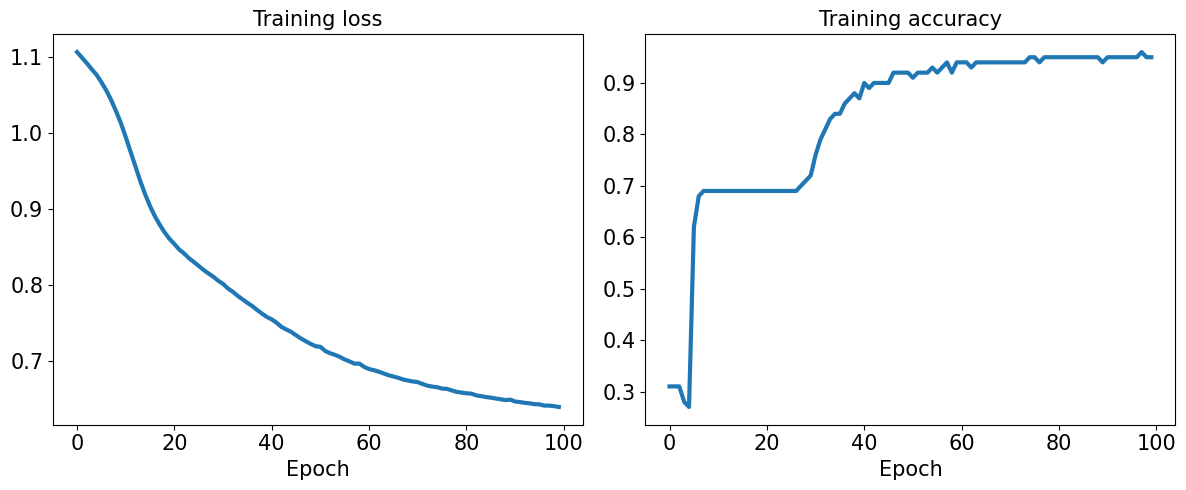

In [39]:


if device.type == 'cuda':
  accuracy_hist = [acc.cpu() for acc in accuracy_hist]



fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()


**Accuracy for test dataset**

In [40]:
# Normalize X_test
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float().to(device)  # Move to device

# Check if y_test is already a tensor and move it to the device
if isinstance(y_test, torch.Tensor):
    y_test = y_test.to(device)  # Move to device
else:
    y_test = torch.from_numpy(y_test).float().to(device)  # Convert from numpy if not already a tensor

# Make predictions
pred_test = model(X_test_norm)

# Move pred_test to CPU if necessary for processing, but ensure both are on the same device
if device.type == 'cuda':
    pred_test = pred_test.cpu()  # Move predictions to CPU

# Make sure y_test is on the same device as pred_test
if y_test.device != pred_test.device:
    y_test = y_test.cpu()  # Move y_test to CPU if needed

# Calculate accuracy
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')


Test Acc.: 0.9800


### Saving and reloading the trained model

In [41]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [42]:
model_new = torch.load(path)
model_new.eval()

<ipython-input-42-ddbeb3503457>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new = torch.load(path)


Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [43]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [44]:
#if you want to save only the learned parameters

path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [45]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<ipython-input-45-b21dbd0d4824>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load(path))


<All keys matched successfully>

In [46]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


### Exercise: train a classification model with 2 (or more) hidden layers



---



### Choosing activation functions for MLP


**Logistic function recap**

In [47]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}')

P(y=1|x) = 0.888


In [48]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas)

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [49]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class)

Predicted class label: 0


**Estimating class probabilities in multiclass classification via the softmax function**

In [50]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [51]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

**Broadening the output spectrum using a hyperbolic tangent**

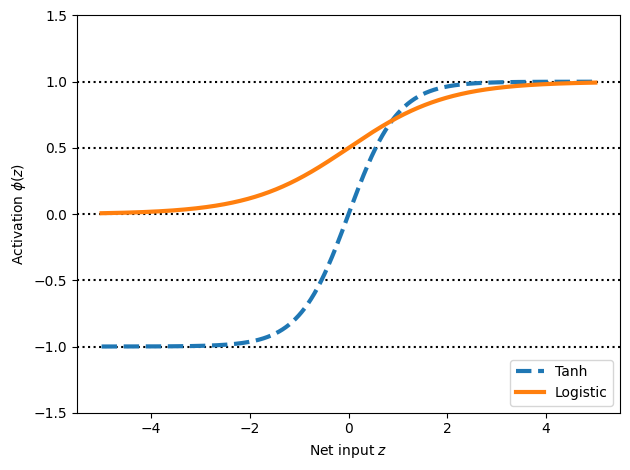

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

We have seen quite. afew activation functions so far...

In [53]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [54]:
torch.tanh(torch.from_numpy(z))


tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [55]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [56]:
torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

In [57]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)



---

**Second Block**

Let's have now a deep dive into autograd in PyTorch

## Autograd in PyTorch


### Basic building blocks of PyTorch

* **Tensors**: PyTorch’s main data structure. If a tensor’s requires_grad attribute is set to True, all operations on it will be tracked by autograd.

* **Computation Graph**: PyTorch builds a dynamic computation graph. Each node in the graph corresponds to a tensor operation (e.g., matrix multiplication, addition), and edges represent gradients between tensors.

* **Backward Pass**: After performing the forward pass, PyTorch can compute gradients by calling .backward() on the loss tensor. This traces back through the graph and accumulates the gradients in the .grad attribute of each leaf tensor.

### Deep dive into autograd in PyTorch

- Implementing backpropagation by hand is like programming in assembly language,
You will never have to do it, but it is important for having mental model of how everything works

- Automatic differentiation (`autodiff`) a general way of taking a program which computes value, and automatically constructs a procedure for computing derivatives of the values.
    * It is **NOT** finite differences. Hence, no “huge” numerical errors are induced. It is linear in cost of computing the values and numerically stable.
    * It is **NOT** Symbolic differentiation as well, which if not optimized could result in redundant expressions.
- Backpropagation is the special case of autodiff applied to neural nets. This is however used synonymously
- Autograd (`autograd`) is the name of the package within PyTorch. It uses reverse automatic differentiation.

- `autograd` will convert program into a sequence of primitive operations which have specified routines for computing derivatives. It is a computing engine.

- `autograd` will record all the operations that created the data as you execute operations (forward pass), creating a Directed Acyclic Graph (DAG).
Leaves are input tensors and roots are the output tensors after an operation. By tracing from roots to leaves, one can compute the gradients using chain rule. Hence it is called as reverse automatic differentiation engine.


**Defining some global settings**

In [59]:
tkwargs = {'dtype': torch.float,
           'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
           }

print (tkwargs)

{'dtype': torch.float32, 'device': device(type='cpu')}


### Example: Basic Autograd in Action

**Step 1: Creating tensors with `requires_grad`**

In [60]:
import torch

# Create a tensor and set requires_grad=True to track its gradients
x = torch.tensor([2.0, 3.0], requires_grad=True, **tkwargs)
y = torch.tensor([1.0, 2.0], requires_grad=True, **tkwargs)
c = torch.tensor([3.0, 4.0], requires_grad=True, **tkwargs)
print (f"x: {x}")
print (f"y: {y}")
print (f"c: {c}")


x: tensor([2., 3.], requires_grad=True)
y: tensor([1., 2.], requires_grad=True)
c: tensor([3., 4.], requires_grad=True)


`requires_grad=True` tells PyTorch to start tracking all operations on these tensors for gradient computation.

### Perform operations on Tensors

In [62]:
# Perform some operations
z = x * y + c
loss = torch.mean(torch.rand(z.shape, **tkwargs) - z) ** 2
print(f"z: {z}")  # z is an intermediate tensor in the computation
print(f"loss: {loss}")  # this is the final result (a scalar)


z: tensor([ 5., 10.], grad_fn=<AddBackward0>)
loss: 47.54528045654297


### Leaf tensor vs root tensor (nodes)

In PyTorch, tensors as a result from operations are different from `base` tensors

#### Leaf Tensors

* Is created by the user (e.g., directly through a tensor creation function like torch.tensor() or torch.randn()).

* Has `requires_grad=True` (meaning it will be tracked for gradient computation).

* Does not result from a differentiable operation (i.e., it is not derived from other tensors that are part of a computational graph).

* **Originating tensor**: It is a tensor that is created by the user and not derived from other operations in the computational graph.

* **Gradient accumulation**: Gradients will accumulate directly in the .grad attribute of leaf tensors during backpropagation.

* **Not further differentiable**: Once you perform operations on a leaf tensor, the result is no longer a leaf tensor because it depends on the leaf tensor(s) through differentiable operations.

#### ROOT tensor

A root tensor is the final tensor in a computational graph. It is typically the tensor on which you call .backward() to initiate the backpropagation process. In most cases, this is a scalar value (e.g., a loss tensor) because gradients are defined with respect to a scalar quantity.

* **End of computation**: The root tensor is the result of all the operations performed during the forward pass.

* **Gradient propagation**: When .backward() is called on the root tensor, the gradients propagate backward through the computational graph, updating all tensors that were part of the graph (particularly leaf tensors with requires_grad=True).

* **Usually a scalar** (not strictly): In practice, the root tensor is often a scalar (e.g., loss), as gradients are typically computed with respect to a single quantity.


> [!NOTE]  Non-leaf tensors do not store gradients. If you need to inspect intermediate gradients, you must keep track of them separately. For example, if you want to compute gradients for non-leaf tensors, you can call `.retain_grad()` on them before performing backpropagation.

In [63]:
print (f"x is a leaf tensor? {x.is_leaf}, {x}")
print (f"y is a leaf tensor? {y.is_leaf}, {y}")
print (f"c is a leaf tensor? {c.is_leaf}, {c}")
print (f"z is a leaf tensor? {z.is_leaf}, {z}")
print (f"loss is a leaf tensor? {loss.is_leaf}, {loss}")

x is a leaf tensor? True, tensor([2., 3.], requires_grad=True)
y is a leaf tensor? True, tensor([1., 2.], requires_grad=True)
c is a leaf tensor? True, tensor([3., 4.], requires_grad=True)
z is a leaf tensor? False, tensor([ 5., 10.], grad_fn=<AddBackward0>)
loss is a leaf tensor? False, 47.54528045654297


### Another Example on leaf and root nodes

Let us consider the following

$$
z = \text{mean}(x * y + c)
$$

*Note how we are implementing these. This will become clear as we go through this notebook*


In [78]:
# Create a tensor and set requires_grad=True to track its gradients
x = torch.tensor([2.0, 3.0], requires_grad=True, **tkwargs)
y = torch.tensor([1.0, 2.0], requires_grad=True, **tkwargs)
c = torch.tensor([3.0, 4.0], requires_grad=True, **tkwargs)

# step 1: multiply x and y
r1 = torch.mul(x, y)
r1.retain_grad()
# step 2: add r1 with c
w = torch.add(r1, c)
# step 3: Take mean of w
z = torch.mean(w)



print (f"x is a leaf tensor? {x.is_leaf}, {x}")
print (f"y is a leaf tensor? {y.is_leaf}, {y}")
print (f"c is a leaf tensor? {c.is_leaf}, {c}")
print (f"r1 is a leaf tensor? {r1.is_leaf}, {r1}")
print (f"w is a leaf tensor? {w.is_leaf}, {w}")
print (f"z is a leaf tensor? {z.is_leaf}, {z}")


x is a leaf tensor? True, tensor([2., 3.], requires_grad=True)
y is a leaf tensor? True, tensor([1., 2.], requires_grad=True)
c is a leaf tensor? True, tensor([3., 4.], requires_grad=True)
r1 is a leaf tensor? False, tensor([2., 6.], grad_fn=<MulBackward0>)
w is a leaf tensor? False, tensor([ 5., 10.], grad_fn=<AddBackward0>)
z is a leaf tensor? False, 7.5


In [79]:
# print the gradients after z.backward()
z.backward(retain_graph = True)


print ("gradients of x", x.grad.tolist())
print ("gradients of y", y.grad.tolist())
print ("gradients of c", c.grad.tolist())

gradients of x [0.5, 1.0]
gradients of y [1.0, 1.5]
gradients of c [0.5, 0.5]


In [72]:
%pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 851.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

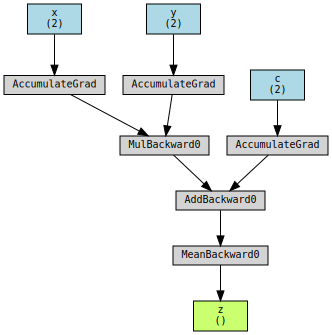

In [73]:
# @title `torchviz`
import torchviz

torchviz.make_dot(z, {'x': x, 'y': y, 'c': c, 'z': z, 'w': w, 'r1': r1})

In [80]:
z

tensor(7.5000, grad_fn=<MeanBackward0>)

In [81]:
#@title Try to compute backward of z again

z.backward()

In [82]:
#@title Can we get gradients $\frac{\partial z}{\partial r_{1}}$?

print (r1.grad) # Mind this is dz_dr1

# Fix it by explicitly tracking its gradient as r1.retain_grad()

tensor([1., 1.])


### Extending to a torch model (classical way)

In [83]:
import torch
import torch.nn as nn

# Example model with named and unnamed parameters
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Named parameters (from layers)
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = SimpleNN()

# Print named parameters
#print("Named Parameters:")
#for name, param in model.named_parameters():
#    print(f"Name: {name}, requires_grad: {param.requires_grad}")

# Print unnamed parameters (using model.parameters())
#print("\nUnnamed Parameters:")
#for param in model.parameters():
#    if param not in model.named_parameters():
#        print(f"Parameter without a name: {param}, requires_grad: {param.requires_grad}")


inputs = torch.rand(1)
outputs = model(inputs)
print ("INPUTS")
print (inputs)

print ("-----------")

print ("outputs")
print (outputs)


INPUTS
tensor([0.2457])
-----------
outputs
tensor([0.5590], grad_fn=<SigmoidBackward0>)


What happened to the intermediate steps? What happened to weights and the intermediate `ReLU`.

### To inspect the entire computational graph we can use `torchviz`


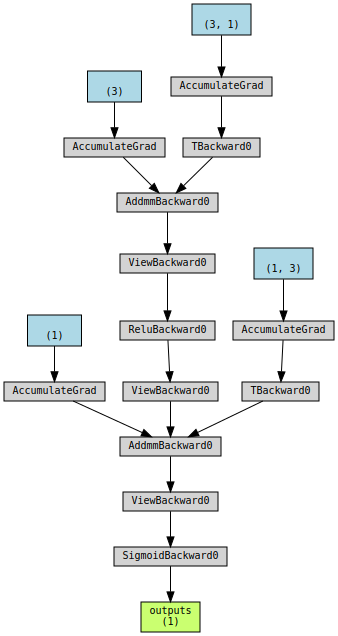

In [84]:
import torchviz

torchviz.make_dot(outputs, {'inputs': inputs, 'outputs': outputs})

### Lets do it with a simpler implementation


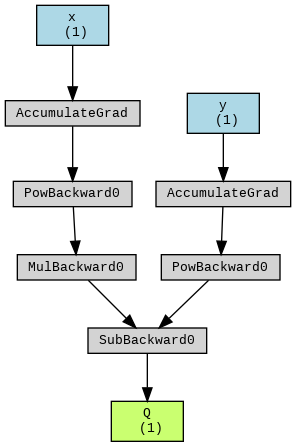

In [85]:
#@title Lets do $Q = 3 x^{2} - y^{2}$
import torch
from torchviz import make_dot

x = torch.randn(1, requires_grad=True)
y = torch.randn(1, requires_grad=True)

Q = 3 * x**2 - y**2

make_dot(Q, params={'x': x, 'y': y, 'Q': Q}).render("Q_graph", format="png")

from IPython.display import Image
Image('Q_graph.png')

### Computing gradients via automatic differentiation and GradientTape


In [86]:
model.fc2.weight.grad

### Computing the gradients of the loss with respect to trainable variables

In [87]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)
z.retain_grad()

loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)


dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [88]:
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


### PyTorch Autodifferentiation vs. Manual Gradient Calculation through Staged Computation

Say from before, if we want to push the value of `z` through a signmoid function, then we can now explore how a complex function can be broken down into a composition of simpler functions. We will demonstrate how automatic differentiation (autodiff) in PyTorch efficiently computes gradients by leveraging the chain rule, thus offering a scalable solution for handling more sophisticated computations.

Consider the task of calculating the gradient of the *sigmoid function*:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
This function can be expressed as a composition of several elementary functions, where $\sigma(z) = s(c(b(a(z))))$. Each of these represents a simple mathematical transformation:

1. $$ a(z) = -z $$

2. $$ b(a) = e^a $$

3. $$ c(b) = 1 + b $$

4. $$ s(c) = \frac{1}{c} $$

By staging the computation, we introduce intermediate variables that correspond to simple expressions. This stepwise approach simplifies the process of calculating local gradients, making each stage straightforward to compute. To find the overall gradient, we can combine these local gradients using the chain rule.

The following figure illustrates the computation graph for this staged process, highlighting the flow of information from the input to the output.

![Gradient Computation Image](https://drive.google.com/uc?id=1xwJOoWH3_n-2zFHlvKTMWNo5KtNmqzxL)

Given an input $x$, and an output represented by node $s$, we aim to compute the derivative of $s$ with respect to $x$, denoted as $\frac{\partial s}{\partial x}$. Using the chain rule, this becomes:
$$
\frac{\partial s}{\partial z} = \frac{\partial s}{\partial c} \cdot \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a} \cdot \frac{\partial a}{\partial z}
$$


This staged manual computation of gradients, while feasible, can become tedious and error-prone, especially as the complexity of the function increases. The real power of PyTorch lies in how it automates this entire process using its built-in autodifferentiation engine.

### How PyTorch Alleviates This

PyTorch's `autograd` mechanism automatically tracks operations performed on tensors and constructs the underlying computation graph dynamically. When the `.backward()` function is called, PyTorch traverses the graph in reverse (backpropagation), efficiently computing gradients using the chain rule, without requiring manual intervention.

#### Benefits of PyTorch's `autograd`:
1. **Automatic Gradient Calculation**: No need to manually apply the chain rule for complex expressions, as PyTorch tracks all operations and calculates gradients for you.
2. **Efficient and Scalable**: PyTorch can handle large-scale models with many parameters, seamlessly updating gradients during training.
3. **Dynamic Graph**: Unlike static frameworks, PyTorch builds the computation graph dynamically during the forward pass. This makes it flexible for models that require runtime decisions, like varying network architectures or data flow.
4. **Error-Free Gradient Computation**: Manual gradient computations, especially in deep networks, can lead to mistakes. PyTorch alleviates this by providing reliable, automatic differentiation, freeing the user to focus on the high-level structure of the model.




In [90]:
import torch
import numpy as np

def sigmoid(x):
    """
    Sigmoid function re-implemented for educational purposes.
    In practice, use `torch.sigmoid` for performance and reliability.
    """
    return 1.0 / (1.0 + torch.exp(-x))

def grad_sigmoid_pytorch(x):
    """
    Computes the gradient of the sigmoid function using PyTorch's autograd.
    This demonstrates how PyTorch's autodiff engine tracks operations and
    computes the gradient automatically.
    """
    # Ensure x requires gradient computation
    x = x.clone().requires_grad_(True)
    # Perform the forward pass
    y = sigmoid(x)
    # Compute the gradient of y w.r.t. x
    y.backward()
    # Return the gradient of x (dy/dx)
    return x.grad

def grad_sigmoid_manual(x):
    """
    Manually computes the gradient of the sigmoid function by breaking down
    the computation into intermediate steps, following the chain rule.

    This process stages the computation, showing each step from the
    forward pass and how local gradients are computed during backpropagation.
    """
    # Forward pass with intermediate steps
    a = -x  # The negation step in the exponent
    b = np.exp(a)  # The exponentiation, e^{-x}
    c = 1 + b  # Adding 1 in the denominator
    s = 1.0 / c  # The final sigmoid output, 1 / (1 + e^{-x})

    # Backward pass (manual computation of gradients)
    dsdc = -1.0 / (c ** 2)  # Gradient of the reciprocal function
    dsdb = dsdc * 1  # Gradient of the addition
    dsda = dsdb * torch.exp(a)  # Gradient of the exponential
    dsdx = dsda * (-1)  # Gradient of the negation (chain rule applied)

    return dsdx

def grad_sigmoid_symbolic(x):
    """
    Computes the gradient of the sigmoid function using the known analytical
    derivative: d(sigmoid(x))/dx = sigmoid(x) * (1 - sigmoid(x)).
    This method leverages the symbolic representation of the gradient.
    """
    # Forward pass: compute sigmoid(x)
    s = sigmoid(x)
    # Compute gradient using the symbolic form of the derivative
    dsdx = s * (1 - s)
    return dsdx

# Input tensor for testing
input_x = torch.tensor([2.0])

# Compare the results of manual, PyTorch autograd, and symbolic gradient computations
print("Autograd (PyTorch):", grad_sigmoid_pytorch(input_x).item())
print("Manual (Staged Computation):", grad_sigmoid_manual(input_x).item())
print("Symbolic (Analytical Derivative):", grad_sigmoid_symbolic(input_x).item())


Autograd (PyTorch): 0.10499356687068939
Manual (Staged Computation): 0.10499357432126999
Symbolic (Analytical Derivative): 0.10499362647533417


### More complex example

Lets now create a more complex example with
- Input Layer - 1
- Hidden Layer - 2
- Ouput Layer - 1




In [91]:
# @title Coding this up manually is harder as you can see.
import torch
import numpy as np

# Activation functions
def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

def relu(x):
    return torch.maximum(torch.tensor(0.0), x)

# Gradient of sigmoid using symbolic derivative
def grad_sigmoid_symbolic(s):
    return s * (1 - s)

# Gradient of ReLU using symbolic derivative
def grad_relu_symbolic(x):
    return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

# Forward pass for multi-layer neural network
def forward_pass(x, w1, w2, w3):
    # Hidden layer 1 (ReLU activation)
    z1 = w1 @ x
    h1 = relu(z1)

    # Hidden layer 2 (Sigmoid activation)
    z2 = w2 @ h1
    h2 = sigmoid(z2)

    # Output layer (no activation)
    z3 = w3 @ h2
    return z1, h1, z2, h2, z3

# Manual backward pass
def backward_pass_manual(x, w1, w2, w3, y_true, z1, h1, z2, h2, y_pred):
    loss = (y_pred - y_true).pow(2).mean()

    grad_output = 2 * (y_pred - y_true)

    grad_w3 = grad_output * h2.T

    # Backprop through layer 2 (Sigmoid)
    grad_h2 = grad_output * w3.T  # Shape: (2, 1)
    grad_z2 = grad_h2 * grad_sigmoid_symbolic(h2)  # Shape: (2, 1)
    grad_w2 = grad_z2 @ h1.T  # Shape: (2, 2)

    # Backprop through layer 1 (ReLU)
    grad_h1 = w2.T @ grad_z2  # Corrected shape: (2, 1)
    grad_z1 = grad_h1 * grad_relu_symbolic(z1)  # Shape: (2, 1)
    grad_w1 = grad_z1 @ x.T  # Shape: (2, 1)

    return grad_w1, grad_w2, grad_w3

# Autograd backward pass
def backward_pass_autograd(x, w1, w2, w3, y_true):
    x.requires_grad_(True)
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    w3.requires_grad_(True)

    _, _, _, _, y_pred = forward_pass(x, w1, w2, w3)

    loss = (y_pred - y_true).pow(2).mean()

    loss.backward()

    return w1.grad, w2.grad, w3.grad

# Initialize weights and input
x = torch.tensor([[1.0]], requires_grad=True)  # Input
w1 = torch.tensor([[0.5], [1.0]], requires_grad=True)  # Weights for layer 1 (2x1)
w2 = torch.tensor([[0.3, -0.7], [0.8, 0.2]], requires_grad=True)  # Weights for layer 2 (2x2)
w3 = torch.tensor([[0.2, -0.4]], requires_grad=True)  # Weights for output layer (1x2)
y_true = torch.tensor([1.0])  # True label (target)

# Forward pass to obtain intermediate values
z1, h1, z2, h2, y_pred = forward_pass(x.detach(), w1.detach(), w2.detach(), w3.detach())

# Compute gradients manually
grad_w1_manual, grad_w2_manual, grad_w3_manual = backward_pass_manual(x.detach(), w1.detach(), w2.detach(), w3.detach(), y_true, z1, h1, z2, h2, y_pred)

# Compute gradients using PyTorch autograd
grad_w1_autograd, grad_w2_autograd, grad_w3_autograd = backward_pass_autograd(x, w1, w2, w3, y_true)

# Display the results
print("Manual Gradients:")
print("grad_w1_manual:", grad_w1_manual)
print("grad_w2_manual:", grad_w2_manual)
print("grad_w3_manual:", grad_w3_manual)

print("\nAutograd Gradients:")
print("grad_w1_autograd:", grad_w1_autograd)
print("grad_w2_autograd:", grad_w2_autograd)
print("grad_w3_autograd:", grad_w3_autograd)


Manual Gradients:
grad_w1_manual: tensor([[0.1405],
        [0.1204]])
grad_w2_manual: tensor([[-0.0550, -0.1100],
        [ 0.1085,  0.2169]])
grad_w3_manual: tensor([[-0.8672, -1.5303]])

Autograd Gradients:
grad_w1_autograd: tensor([[0.1405],
        [0.1204]])
grad_w2_autograd: tensor([[-0.0550, -0.1100],
        [ 0.1085,  0.2169]])
grad_w3_autograd: tensor([[-0.8672, -1.5303]])


### Computing the gradient of a functional form as well. Just making sure we understand the math.


Let us consider to compute the value

$$f(x) = \sin{(x)}$$
where $x \in [0, 2\pi]$

In [92]:
# create a linspace in x from -5 to 5
x = torch.linspace(0., 2*torch.pi, 100, requires_grad=True, **tkwargs)
z = torch.sin(x)
# torch.autograd.grad() computes the gradient of z with respect to x using chain rule.
# grad_outputs is the gradient of the output with respect to z.
# This is where various layer outputs can be used to compute the gradient of the loss with respect to the input.
dz_dx = torch.autograd.grad(outputs=z, inputs=x, grad_outputs=z.data.new(z.shape).fill_(1), create_graph=True)[0]
# This is same as
# dz_dx = z.backward(torch.ones_like(z), retain_graph=True) # oneslike(z) is equivalent to grad_outputs

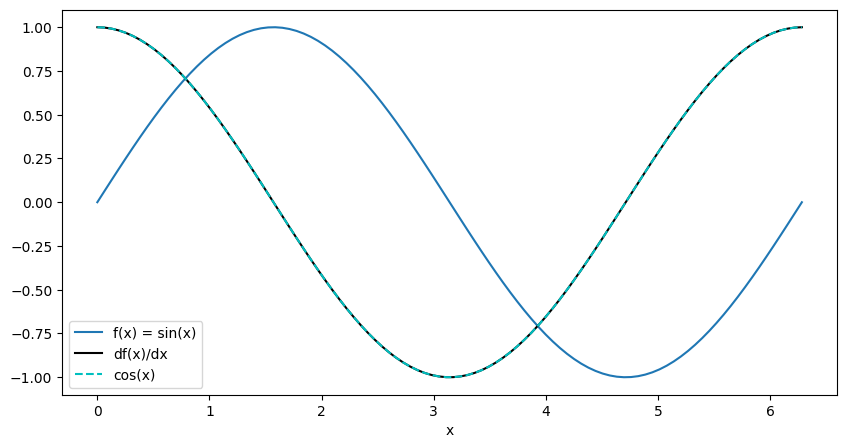

In [93]:
import matplotlib.pyplot as plt

with torch.no_grad(): # do not compute gradients for plotting
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    # Since GPU() is used, we need to move the tensor back to the CPU
    axes.plot(x.cpu().numpy(), z.cpu().numpy(), label='f(x) = sin(x)')
    axes.plot(x.cpu().numpy(), dz_dx.cpu().numpy(), "k-", label="df(x)/dx")
    axes.plot(x.cpu().numpy(), torch.cos(x).cpu().numpy(), "c--", label="cos(x)")
    axes.legend()
    axes.set_xlabel('x')

    plt.show()
